<a href="https://colab.research.google.com/github/bubriks/ID2223/blob/main/Lab2/s-bert_lab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LAB-2 - Paolo Teta & Ralfs Zangis
---
useful:
https://www.sbert.net/examples/training/sts/README.html#training-data

### Setup Colab (do NOT execute)

In [1]:
# from google.colab import drive
# import os

# !pip install pyspark
# !pip install --upgrade tensorflow_hub
# !pip install --upgrade tensorflow_text

# from pyspark.sql import SparkSession
# from pyspark.sql.functions import *
# from pyspark.sql.types import *

# spark = SparkSession.builder.getOrCreate()

# drive.mount('/content/gdrive')
# # os.mkdir("/content/gdrive/MyDrive/ID2223-repo/")

# # os.chdir("/content/gdrive/MyDrive/ID2223-repo/")
# # !git clone https://github.com/bubriks/ID2223.git

# os.chdir("/content/gdrive/MyDrive/ID2223-repo/ID2223/Lab2/")
# !git pull

# # ------------------------------ #

# schema = StructType([
#     StructField("genre", StringType(), True),
#     StructField("filename", StringType(), True),
#     StructField("year", StringType(), True),
#     StructField("year_id", IntegerType(), True),
#     StructField("score", FloatType(), True),
#     StructField("sentence1", StringType(), True),
#     StructField("sentence2", StringType(), True)])

# train = spark.read.csv("/content/gdrive/MyDrive/ID2223-repo/ID2223/Lab2/stsbenchmark/sts-test.csv", sep ='\t', header=False, schema=schema)
# test = spark.read.csv("/content/gdrive/MyDrive/ID2223-repo/ID2223/Lab2/stsbenchmark/sts-test.csv", sep ='\t', header=False, schema=schema)
# dev = spark.read.csv("/content/gdrive/MyDrive/ID2223-repo/ID2223/Lab2/stsbenchmark/sts-dev.csv", sep ='\t', header=False, schema=schema)

# START

In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *

spark = SparkSession.builder.getOrCreate()

In [3]:
# !pip install --upgrade tensorflow_hub
# !pip install --upgrade tensorflow_text

import tensorflow as tf
import transformers
import functools
import numpy as np

from transformers import BertTokenizer, TFBertModel

In [4]:
schema = StructType([
    StructField("genre", StringType(), True),
    StructField("filename", StringType(), True),
    StructField("year", StringType(), True),
    StructField("year_id", IntegerType(), True),
    StructField("score", FloatType(), True),
    StructField("sentence1", StringType(), True),
    StructField("sentence2", StringType(), True)])

train = spark.read.csv("stsbenchmark/sts-train.csv", sep ='\t', header=False, schema=schema)
test = spark.read.csv("stsbenchmark/sts-test.csv", sep ='\t', header=False, schema=schema)
dev = spark.read.csv("stsbenchmark/sts-dev.csv", sep ='\t', header=False, schema=schema)

train.show()

+-------------+--------+--------+-------+-----+--------------------+--------------------+
|        genre|filename|    year|year_id|score|           sentence1|           sentence2|
+-------------+--------+--------+-------+-----+--------------------+--------------------+
|main-captions|  MSRvid|2012test|      1|  5.0|A plane is taking...|An air plane is t...|
|main-captions|  MSRvid|2012test|      4|  3.8|A man is playing ...|A man is playing ...|
|main-captions|  MSRvid|2012test|      5|  3.8|A man is spreadin...|A man is spreadin...|
|main-captions|  MSRvid|2012test|      6|  2.6|Three men are pla...|Two men are playi...|
|main-captions|  MSRvid|2012test|      9| 4.25|A man is playing ...|A man seated is p...|
|main-captions|  MSRvid|2012test|     11| 4.25|Some men are figh...|Two men are fight...|
|main-captions|  MSRvid|2012test|     12|  0.5|   A man is smoking.|   A man is skating.|
|main-captions|  MSRvid|2012test|     13|  1.6|The man is playin...|The man is playin...|
|main-capt

## Normalize score column

In [5]:
train = train.withColumn("score", col("score")/2.5-1)
test = test.withColumn("score", col("score")/2.5-1)
dev = dev.withColumn("score", col("score")/2.5-1)

dev.select("score").describe().show()

+-------+--------------------+
|summary|               score|
+-------+--------------------+
|  count|                1500|
|   mean|-0.05443697837591158|
| stddev|  0.6001942581590352|
|    min|                -1.0|
|    max|                 1.0|
+-------+--------------------+



## Tokenize sentences

In [6]:
from itertools import repeat

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

max_array = 200

def tokenize(text):
    array = np.array(tokenizer(text or "", return_tensors='tf', padding=True)["input_ids"][0]).tolist()
    diff = max_array - len(array)
    if(diff>0):
        array = array + list(repeat(0, diff))
    elif(diff<0):
        array = array[0:max_array]
    return array

tokenizeUDF = udf(lambda text: tokenize(text), ArrayType(IntegerType())) 

train = train.withColumn("sentence1_tokenized", tokenizeUDF(col("sentence1")))
train = train.withColumn("sentence2_tokenized", tokenizeUDF(col("sentence2")))
test = test.withColumn("sentence1_tokenized", tokenizeUDF(col("sentence1")))
test = test.withColumn("sentence2_tokenized", tokenizeUDF(col("sentence2")))
dev = dev.withColumn("sentence1_tokenized", tokenizeUDF(col("sentence1")))
dev = dev.withColumn("sentence2_tokenized", tokenizeUDF(col("sentence2")))

In [7]:
print(train.select("sentence2_tokenized").collect()[1])

Row(sentence2_tokenized=[101, 1037, 2158, 2003, 2652, 1037, 8928, 1012, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


## Input layer

In [8]:
input_ids_1 = tf.keras.layers.Input(shape=(1,), dtype=tf.int32, name='input_ids_1')
input_ids_2 = tf.keras.layers.Input(shape=(1,), dtype=tf.int32, name='input_ids_2')

## BERT encoder layer

In [9]:
transformers.logging.set_verbosity_error() # to not show warnings

output_1 = TFBertModel.from_pretrained("bert-base-uncased", trainable=True, name="bert_1")(input_ids=input_ids_1)
output_2 = TFBertModel.from_pretrained("bert-base-uncased", trainable=True, name="bert_2")(input_ids=input_ids_2)

## Pooled output

In [10]:
pooled_1 = tf.reduce_mean(output_1.last_hidden_state, 1, name="pool_1")
pooled_2 = tf.reduce_mean(output_2.last_hidden_state, 1, name="pool_2")

# Regression
***

## Cosine similarity

In [11]:
cos_distance = tf.keras.layers.Dot(axes=1, normalize=True, name="cosine_sim")([pooled_1, pooled_2])

## Model

In [12]:
regression_model = tf.keras.Model(inputs=[input_ids_1, input_ids_2], outputs=[cos_distance])

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids_1 (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 input_ids_2 (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 bert_1 (TFBertModel)           TFBaseModelOutputWi  109482240   ['input_ids_1[0][0]']            
                                thPoolingAndCrossAt                                               
                                tentions(last_hidde                                               
                                n_state=(None, None                                           

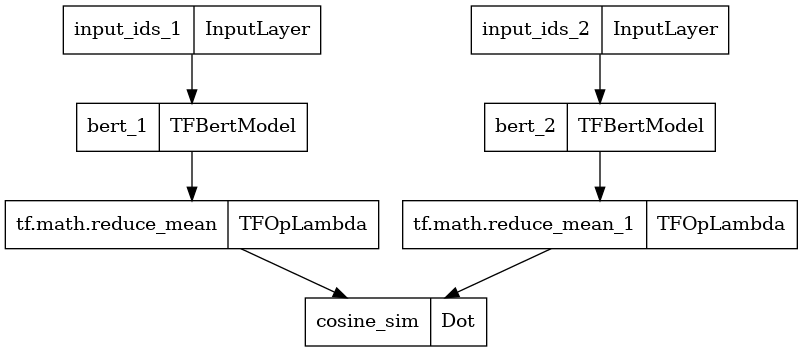

In [13]:
regression_model.summary()
tf.keras.utils.plot_model(regression_model)

## Compile

In [14]:
optimizer = tf.optimizers.Adam(0.001)
mse = tf.keras.losses.MeanSquaredError()
accuracy = tf.keras.metrics.Accuracy()

regression_model.compile(optimizer=optimizer, loss=mse, metrics=accuracy)

## Training

In [ ]:
df_train = train.select("sentence1_tokenized","sentence2_tokenized","score").toPandas()

sent_1 = tf.convert_to_tensor(df_train["sentence1_tokenized"].values.tolist(), dtype=tf.float32)
sent_2 = tf.convert_to_tensor(df_train["sentence2_tokenized"].values.tolist(), dtype=tf.float32)

regression_model.fit([sent_1,sent_2], df_train["score"], epochs=1)
#model.predict([encoded_input_1["input_ids"],encoded_input_2["input_ids"]])

# Classification
***

## Concatenate the sentence representations

In [ ]:
num_labels = 2

diff = tf.keras.layers.Subtract()([pooled_1, pooled_2])
# pooled_1.shape[1] == number of features
weights = tf.Variable(tf.random.truncated_normal([pooled_1.shape[1], num_labels]))
multi = tf.matmul(diff, weights)
softmax = tf.nn.softmax(multi)

## Model

In [ ]:
classification_model = tf.keras.Model(inputs=[input_ids_1, input_ids_2], outputs=[softmax])

In [ ]:
classification_model.summary()
tf.keras.utils.plot_model(classification_model)

## Compile

In [ ]:
optimizer = tf.optimizers.Adam(0.001)
mse = tf.keras.losses.CategoricalCrossentropy()
accuracy = tf.keras.metrics.Accuracy()

classification_model.compile(optimizer=optimizer, loss=mse, metrics=accuracy)